# **Deep Learning -  Homework - II. Milestone**
---

Group Members: El-Ali Maya (BHI5LF), Simkó Máté (O3BMRX)

###**Chosen task: Friend recommendation with graph neural networks**
###**Dataset: [Facebook Dataset](https://snap.stanford.edu/data/ego-Facebook.html)**


# Imports

In [39]:
# install dgl
! pip install  dgl -f https://data.dgl.ai/wheels/cu118/repo.html
! pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html
! pip install torchmetrics

Looking in links: https://data.dgl.ai/wheels/cu118/repo.html
Looking in links: https://data.dgl.ai/wheels-test/repo.html


In [40]:
import os

import itertools

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve


import scipy.sparse as sp

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import BinaryAccuracy

import networkx as nx
import dgl
from dgl.nn import GraphConv

# Data

In [41]:
# download the dataset
! wget "https://snap.stanford.edu/data/facebook.tar.gz"
! wget "https://snap.stanford.edu/data/facebook_combined.txt.gz"

--2023-11-19 09:12:47--  https://snap.stanford.edu/data/facebook.tar.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 732104 (715K) [application/x-gzip]
Saving to: ‘facebook.tar.gz.3’

facebook.tar.gz.3   100%[===================>] 714.95K  4.43MB/s    in 0.2s    

2023-11-19 09:12:47 (4.43 MB/s) - ‘facebook.tar.gz.3’ saved [732104/732104]

--2023-11-19 09:12:47--  https://snap.stanford.edu/data/facebook_combined.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 218576 (213K) [application/x-gzip]
Saving to: ‘facebook_combined.txt.gz.3’

facebook_combined.t 100%[===================>] 213.45K  --.-KB/s    in 0.1s    

2023-11-19 09:12:48 (2.10 MB/s) - ‘facebook_combined.txt.gz

In [42]:
# unpack the dataset
! mkdir "data"
! tar -xzf facebook.tar.gz -C /content/data
! gunzip -c facebook_combined.txt.gz > /content/data/facebook_combined.txt

mkdir: cannot create directory ‘data’: File exists


In [43]:
# get the ego users of the subgraphs
folder_path = "/content/data/facebook"
ego_users = []

for filename in os.listdir(folder_path):
    if os.path.isfile(os.path.join(folder_path, filename)):
        # Split the filename and extension
        name, _ = os.path.splitext(filename)
        ego_users.append(int(name))

ego_users = list(set(ego_users))

print(ego_users)

[0, 107, 3980, 3437, 686, 1684, 1912, 698, 348, 414]


## Utility functions

In [44]:
# function for mapping node labels to node indeces,
# because in most graph the labels don't start at 0 and aren't continuous
def get_index_dicts(node_labels):
  node_labels = sorted(node_labels)

  index_to_label = {}
  label_to_index = {}
  for idx, node_label in enumerate(node_labels):
      index_to_label[idx] = node_label
      label_to_index[node_label] = idx
  return index_to_label, label_to_index

In [45]:
# creates a DGL graph object for each subgraph
def get_dgl_graph(user_id, ego_users):
  # check the id
  if user_id not in ego_users:
    raise Exception("Subgraph not available for user {}".format(user_id))

  # load the data files
  edge_data_file = "/content/data/facebook/{}.edges".format(user_id)
  feat_data_file = "/content/data/facebook/{}.feat".format(user_id)

  # feature data
  feats = []
  node_labels = []
  with open(feat_data_file) as f:  # load node features file
      for line in f:
          node_labels.append(int(line.split()[0])) # first element in row is the node label
          a = [int(x) for x in line.split()[1:]]  # the others are one-hot encoded categorical labels
          feats.append(torch.tensor(a, dtype=torch.float))
  feats = torch.stack(feats) # concat the features to a single tensor

  # mapping node_labels to indeces
  idx_to_lab_dict, lab_to_idx_dict = get_index_dicts(node_labels)

  # edge data
  edges_u, edges_v = [], []
  with open(edge_data_file) as f:  # load edges file
      for line in f:
          edges_u.append(int(line.split()[0]))
          edges_v.append(int(line.split()[1]))

  # transform node_labels to indeces
  edges_u = [lab_to_idx_dict[x] for x in edges_u]
  edges_v = [lab_to_idx_dict[x] for x in edges_v]
  edges_u, edges_v = np.array(edges_u), np.array(edges_v)

  # Construct graph
  G = dgl.DGLGraph()
  G.add_nodes(len(node_labels)) # nodes
  G.add_edges(edges_u, edges_v) # edges
  G.ndata['feat'] = feats # feature data
  G.ndata['ego_user'] = torch.full((G.ndata['feat'].shape[0],1), user_id) # the ego user who is connected to all nodes in the graph
  G.ndata['node_label'] = torch.tensor(list(idx_to_lab_dict.values()), dtype=torch.int) # the node labels

  return G

In [46]:
#defining a function for dataset visualisation
def visualize(labels, g, node_size=100, pos = None, file_name = None, title = ""):
    # if there isn't a pre calculated layout
    if (pos == None):
      pos = nx.spring_layout(g, seed=1)

    figsize=(16,16)
    line_style='dotted'

    plt.figure(figsize=figsize)
    plt.axis('off')
    nx.draw_networkx(g, pos=pos, node_size=node_size, cmap=plt.get_cmap('coolwarm'), node_color = labels,
                     edge_color='k', style=line_style, arrows=False, width=0.5, with_labels=False)
    plt.title(title)
    plt.show()

    if (file_name != None):
      plt.savefig(file_name)

## Ego Subgraphs

In [47]:
# read in the ego subgraphs
ego_graphs = []
for user_id in ego_users:
  g = get_dgl_graph(user_id, ego_users)
  ego_graphs.append(g)
ego_graphs

/usr/local/lib/python3.10/dist-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


[Graph(num_nodes=347, num_edges=5038,
       ndata_schemes={'feat': Scheme(shape=(224,), dtype=torch.float32), 'ego_user': Scheme(shape=(1,), dtype=torch.int64), 'node_label': Scheme(shape=(), dtype=torch.int32)}
       edata_schemes={}),
 Graph(num_nodes=1045, num_edges=53498,
       ndata_schemes={'feat': Scheme(shape=(576,), dtype=torch.float32), 'ego_user': Scheme(shape=(1,), dtype=torch.int64), 'node_label': Scheme(shape=(), dtype=torch.int32)}
       edata_schemes={}),
 Graph(num_nodes=59, num_edges=292,
       ndata_schemes={'feat': Scheme(shape=(42,), dtype=torch.float32), 'ego_user': Scheme(shape=(1,), dtype=torch.int64), 'node_label': Scheme(shape=(), dtype=torch.int32)}
       edata_schemes={}),
 Graph(num_nodes=547, num_edges=9626,
       ndata_schemes={'feat': Scheme(shape=(262,), dtype=torch.float32), 'ego_user': Scheme(shape=(1,), dtype=torch.int64), 'node_label': Scheme(shape=(), dtype=torch.int32)}
       edata_schemes={}),
 Graph(num_nodes=170, num_edges=3312,
       

# Data Preparation

We create an inverse of the graphs: G(V,E) is the original graph, invG(V, invE) is the inverse graph. Both graphs have the same nodes and in invG there is a edge between two nodes precisely when there isn't one in G.

This will be used to evaluate whether the model correctly predicts the missing edges as well.

In [10]:
def inverse_edges(G):
  u, v = G.edges()

  # Find all negative edges
  adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy()))) # sparse adjencency matrix
  adj_neg = 1 - adj.todense() - np.eye(G.number_of_nodes())  # substract the og adjacency matrix and the self loops from the identity matrix
  neg_u, neg_v = np.where(adj_neg != 0)

  return neg_u, neg_v

Usually for a friend recommendation system for the train/test split we split the data in time: the train set would be the edges at a given time, and the test set would be the edges at a later time. However this is not available for this dataset, so we split the edges randomly into 3 sets: training, validation and test

In [11]:
def split_graph(g, TEST_RATIO = 0.2, VAL_RATIO = 0.1):
  # for recreatability
  np.random.seed(42)

  # edges
  u, v = g.edges()

  # edge ids
  eids = np.arange(g.number_of_edges())
  eids = np.random.permutation(eids) # random permutation, for randomness in split
  test_size = int(len(eids) * TEST_RATIO)  # number of edges in test set
  val_size = int(len(eids) * VAL_RATIO)   # number of edges in val set
  train_size = g.number_of_edges() - test_size - val_size # number of edges in train set

  # get positive edges for test and train -> split the edge data
  test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
  val_pos_u, val_pos_v = u[eids[test_size:test_size + val_size]], v[eids[test_size:test_size + val_size]]
  train_pos_u, train_pos_v = u[eids[test_size + val_size:]], v[eids[test_size + val_size:]]

  # Find all negative edges
  neg_u, neg_v = inverse_edges(g)

  # split the negative edges
  neg_eids =  np.random.choice(len(neg_u), g.number_of_edges()) # get the same number of negative edges
  # split the data
  test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
  val_neg_u, val_neg_v = neg_u[neg_eids[test_size:test_size + val_size]], neg_v[neg_eids[test_size:test_size + val_size]]
  train_neg_u, train_neg_v = neg_u[neg_eids[test_size + val_size:]], neg_v[neg_eids[test_size + val_size:]]

  # construct positive and negative graphs
  train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
  train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

  val_pos_g = dgl.graph((val_pos_u, val_pos_v), num_nodes=g.number_of_nodes())
  val_neg_g = dgl.graph((val_neg_u, val_neg_v), num_nodes=g.number_of_nodes())

  test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
  test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

  # training graph
  train_g = dgl.remove_edges(g, eids[:test_size + val_size])
  train_g = dgl.add_self_loop(train_g)

  return {
      'graph': train_g,
      'train_graph': (train_pos_g, train_neg_g),
      'val_graph': (val_pos_g, val_neg_g),
      'test_graph': (test_pos_g, test_neg_g)
      }

In [12]:
split_ego_graphs = []
for g in ego_graphs:
  split_ego_graphs.append(split_graph(g))

In [13]:
split_ego_graphs

[{'graph': Graph(num_nodes=347, num_edges=3875,
        ndata_schemes={'feat': Scheme(shape=(224,), dtype=torch.float32), 'ego_user': Scheme(shape=(1,), dtype=torch.int64), 'node_label': Scheme(shape=(), dtype=torch.int32)}
        edata_schemes={}),
  'train_graph': (Graph(num_nodes=347, num_edges=3528,
         ndata_schemes={}
         edata_schemes={}),
   Graph(num_nodes=347, num_edges=3528,
         ndata_schemes={}
         edata_schemes={})),
  'val_graph': (Graph(num_nodes=347, num_edges=503,
         ndata_schemes={}
         edata_schemes={}),
   Graph(num_nodes=347, num_edges=503,
         ndata_schemes={}
         edata_schemes={})),
  'test_graph': (Graph(num_nodes=347, num_edges=1007,
         ndata_schemes={}
         edata_schemes={}),
   Graph(num_nodes=347, num_edges=1007,
         ndata_schemes={}
         edata_schemes={}))},
 {'graph': Graph(num_nodes=1045, num_edges=38495,
        ndata_schemes={'feat': Scheme(shape=(576,), dtype=torch.float32), 'ego_user': Schem

# Model definition

We firstly compute the node embeddings using a GCN, and then we predict whether an edge exists by taking the dot product of its nodes and applying that score to the edges.

In [14]:
# build an ordinary GCN model
class GCN(nn.Module):
  def __init__(self, g, in_feats, n_hidden, n_layers, bottleneck = False, activation = F.relu, dropout = 0):
    super(GCN, self).__init__()
    self.g = g
    self.layers = nn.ModuleList()
    # input layer
    self.layers.append(GraphConv(in_feats, n_hidden, activation=activation))
    # hidden layers
    if bottleneck:
      width = n_hidden
      for i in range(n_layers - 1):
        self.layers.append(GraphConv(width, width//2, activation=activation))
        width = width // 2
      # output layer
      self.layers.append(GraphConv(width, width))
    else:
      for i in range(n_layers - 1):
        self.layers.append(GraphConv(n_hidden, n_hidden, activation=activation))
      # output layer
      self.layers.append(GraphConv(n_hidden, n_hidden))
    self.dropout = nn.Dropout(p=dropout)

  def forward(self, features):
    # the H matrix is the feature matrix
    h = features
    # the matrix passes through each layer
    for i, layer in enumerate(self.layers):
      if i != 0:
        h = self.dropout(h)       #dropout
      h = layer(self.g, h)
    return h

In [15]:
# edge predictors
# simple dot predictor
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(dgl.function.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

# MLP edge predictor
# Simple two layer MLP
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    # Computes a scalar score for each edge of the given graph.
    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1) # get the embeddings of the src and dst nodes
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

# Training pipeline

In [16]:
# utility functions
def compute_loss(pos_score, neg_score):  # computes the loss based on binary cross entropy
        scores = torch.cat([pos_score, neg_score])
        labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
        return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):  # computes AUC (Area-Under-Curve) score
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

def compute_acc(pos_score, neg_score): # computes simple accuracy metric
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    acc = BinaryAccuracy()
    return acc(scores, labels)

In [17]:
#class for early stopping
class EarlyStopping:
    def __init__(self, patience=1):
        self.patience = patience
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > self.min_validation_loss:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [18]:
# defining a train function
def train(model, predictor, split_graph, params, num_epochs = 100, patience = -1, verbose = True, save_history = True, log_freq = 5, log_root = "logs", model_save_freq = -1):
  # get the data
  train_g = split_graph['graph']
  train_pos_g, train_neg_g = split_graph['train_graph']
  val_pos_g, val_neg_g = split_graph['val_graph']
  test_pos_g, test_neg_g = split_graph['test_graph']
  ego_user = train_g.ndata['ego_user'].numpy()[0][0]

  # for logging purposes
  all_train_loss = []
  all_train_accuracy = []
  all_val_loss = []
  all_val_accuracy = []

  run_id = -1
  # log_folder
  os.makedirs("{}/runs/{}".format(log_root, ego_user), exist_ok=True)
  if save_history:
    # get run id
    entries = os.listdir("{}/runs/{}".format(log_root, ego_user))
    folders = [entry for entry in entries if os.path.isdir(os.path.join("{}/{}".format(log_root, ego_user), entry))]
    run_id = len(folders)
    log_folder = "{}/runs/{}/run_{}".format(log_root, ego_user, run_id)
    os.makedirs(log_folder, exist_ok=True)

    # log config
    pd.DataFrame(params, index = [0]).to_csv("{}/runs/{}/run_{}/params.csv".format(log_root, ego_user, run_id), index = False)

  # Early stopping
  if(patience != -1):
    early_stopper = EarlyStopping(patience)

  # optimizer
  optimizer = torch.optim.Adam(itertools.chain(model.parameters(), predictor.parameters()), lr=params["lr"])

  # best loss for saving the best model
  best_val_loss = np.inf

  # training
  for epoch in range(num_epochs):
    # forward
    h = model(train_g.ndata['feat'])  # get node embeddings
    # train data
    train_pos_score = predictor(train_pos_g, h)
    train_neg_score = predictor(train_neg_g, h)
    # validation data
    with torch.no_grad():
      val_pos_score = predictor(val_pos_g, h)
      val_neg_score = predictor(val_neg_g, h)

    #compute loss
    train_loss = compute_loss(train_pos_score, train_neg_score)
    val_loss = compute_loss(val_pos_score, val_neg_score)

    #calculate accuracy
    train_acc = compute_acc(train_pos_score, train_neg_score)
    val_acc = compute_acc(val_pos_score, val_neg_score)

    #early stopping
    if patience != -1 and early_stopper.early_stop(val_loss):
      if verbose:
        print("Early stopping has occured!")
      break

    #save data
    all_train_loss.append(train_loss.item())
    all_train_accuracy.append(train_acc.item())
    all_val_loss.append(val_loss.item())
    all_val_accuracy.append(val_acc.item())

    #save the model
    if save_history:
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model, "{}/best.pt".format(log_folder))

    #training the model
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # save the model if needed
    if model_save_freq != -1 and epoch % model_save_freq == 0:
      torch.save(model, "{}/runs/{}/run_{}/{}.pt".format(log_root, ego_user, run_id, epoch))

    if verbose and epoch % log_freq == 0:
      print('Epoch %d | Train Loss: %.4f | Train Accuracy: % .4f | Valid Loss: %.4f | Valid Accuracy: % .4f' % (epoch, train_loss.item(), train_acc, val_loss.item(), val_acc))


  # save the train_ history
  history = pd.DataFrame({"train_loss": all_train_loss,
                          "train_acc": all_train_accuracy,
                          "val_loss": all_val_loss,
                          "val_acc": all_val_accuracy})
  if save_history:
    history.to_csv("{}/history.csv".format(log_folder), index = False)

  return  run_id, history

In [19]:
# create log folder
! mkdir logs

mkdir: cannot create directory ‘logs’: File exists


# Choose a graph

In [117]:
graph = split_ego_graphs[3]
ego_user = ego_users[3]
ego_user

3437

# Hyperparameter optimisation

In [118]:
# Hyperparameters to optimise
hyp_opt_conf = {
    'opt_n_hidden' : [16,32,64,128],
    'opt_n_layers' : [1,2,3,4,5],
    'opt_dropout' : [0,0.3,0.5,0.8],
    'opt_bottleneck' : [True, False],
    'opt_lr' : [0.01, 0.1, 0.001, 0.0001] #learning_rate
}

In [119]:
def hyp_opt(split_graph, hyp_opt_conf, num_epochs = 30, log_root = "logs"):
  ego_user = split_graph['graph'].ndata['ego_user'].numpy()[0][0]
  best_loss = np.inf
  best_parameters = {}

  history = []

  # log_folder
  os.makedirs("{}/hyp_opt".format(log_root), exist_ok=True)

  for n_hidden in hyp_opt_conf['opt_n_hidden']:
    for n_layers in hyp_opt_conf['opt_n_layers']:
      for dropout in hyp_opt_conf['opt_dropout']:
          for lr in hyp_opt_conf['opt_lr']:
            for bottleneck in hyp_opt_conf['opt_bottleneck']:
              # initialising
              params = {'n_hidden' : n_hidden, 'n_layers': n_layers, 'dropout': dropout, 'lr': lr, 'bottleneck': bottleneck}

              model = GCN(g = split_graph['graph'], in_feats = split_graph['graph'].ndata['feat'].shape[1], n_layers= n_layers, n_hidden = n_hidden, bottleneck = bottleneck, dropout = dropout)
              pred = DotPredictor()

              print("\nn_hidden: %d, n_layers: %d, dropout: %f, lr: %f, bottleneck: %d"%(n_hidden,n_layers, dropout, lr, bottleneck))

              #training for 30 epochs
              _, h = train(model, pred, split_graph = split_graph, params = params, num_epochs = num_epochs, patience = 3, verbose = False, save_history = False)

              parameters = {'n_hidden' : n_hidden, 'n_layers': n_layers, 'dropout': dropout, 'lr': lr, 'bottleneck': bottleneck,
                            'train loss': h['train_loss'].iloc[-1], 'train accuracy': h['train_acc'].iloc[-1], 'val loss': h['val_loss'].iloc[-1], 'val accuracy': h['val_acc'].iloc[-1]}
              history.append(parameters)

              print("Validation Loss: " + str(h['val_loss'].iloc[-1]))

              #saving the best loss
              if h['val_loss'].iloc[-1] < best_loss:
                best_loss = h['val_loss'].iloc[-1]
                best_parameters = parameters

  history = pd.DataFrame(history)
  history.to_csv("{}/hyp_opt/{}.csv".format(log_root, ego_user), index = False)
  return best_loss, best_parameters, history

In [120]:
best_loss, best_parameters, history = hyp_opt(graph, hyp_opt_conf)


n_hidden: 16, n_layers: 1, dropout: 0.000000, lr: 0.010000, bottleneck: 1
Validation Loss: 0.4736481010913849

n_hidden: 16, n_layers: 1, dropout: 0.000000, lr: 0.010000, bottleneck: 0
Validation Loss: 0.4706956744194031

n_hidden: 16, n_layers: 1, dropout: 0.000000, lr: 0.100000, bottleneck: 1
Validation Loss: 1.1105530261993408

n_hidden: 16, n_layers: 1, dropout: 0.000000, lr: 0.100000, bottleneck: 0
Validation Loss: 5.035387992858887

n_hidden: 16, n_layers: 1, dropout: 0.000000, lr: 0.001000, bottleneck: 1
Validation Loss: 0.6357889175415039

n_hidden: 16, n_layers: 1, dropout: 0.000000, lr: 0.001000, bottleneck: 0
Validation Loss: 0.648242712020874

n_hidden: 16, n_layers: 1, dropout: 0.000000, lr: 0.000100, bottleneck: 1
Validation Loss: 0.6815374493598938

n_hidden: 16, n_layers: 1, dropout: 0.000000, lr: 0.000100, bottleneck: 0
Validation Loss: 0.6806393265724182

n_hidden: 16, n_layers: 1, dropout: 0.300000, lr: 0.010000, bottleneck: 1
Validation Loss: 0.5213030576705933

n_

In [121]:
print(best_loss)
print(best_parameters)

0.4434831142425537
{'n_hidden': 128, 'n_layers': 1, 'dropout': 0.5, 'lr': 0.01, 'bottleneck': False, 'train loss': 0.4315115511417389, 'train accuracy': 0.824454665184021, 'val loss': 0.4434831142425537, 'val accuracy': 0.8071725368499756}


In [122]:
history.sort_values('val loss')

,n_hidden,n_layers,dropout,lr,bottleneck,train loss,train accuracy,val loss,val accuracy
497,128,1,0.5,0.01,False,4.315116e-01,0.824455,4.434831e-01,0.807173
321,64,1,0.0,0.01,False,4.306276e-01,0.826013,4.454478e-01,0.813929
337,64,1,0.5,0.01,False,4.506146e-01,0.804570,4.534101e-01,0.799376
160,32,1,0.0,0.01,True,4.381011e-01,0.820448,4.534760e-01,0.804574
480,128,1,0.0,0.01,True,4.486767e-01,0.808725,4.544913e-01,0.803015
...,...,...,...,...,...,...,...,...,...
579,128,4,0.0,0.10,False,1.562794e+05,0.500000,1.523984e+05,0.500000
595,128,4,0.5,0.10,False,1.253503e+06,0.500000,1.240148e+06,0.500000
619,128,5,0.3,0.10,False,1.504693e+06,0.500000,1.484822e+06,0.500000
627,128,5,0.5,0.10,False,2.022781e+06,0.500000,2.003314e+06,0.500000


# Training

In [123]:
# initialising
split_graph = graph
model = GCN(g = split_graph['graph'], in_feats = split_graph['graph'].ndata['feat'].shape[1],
            n_layers= best_parameters['n_layers'], n_hidden = best_parameters['n_hidden'],
            bottleneck = best_parameters['bottleneck'], dropout = best_parameters['dropout'])
pred = DotPredictor()

In [124]:
id, run_history = train(model, pred, split_graph = graph, params = best_parameters, num_epochs = 300,
              patience = 4, log_freq= 1)

Epoch 0 | Train Loss: 0.7602 | Train Accuracy:  0.5000 | Valid Loss: 0.7613 | Valid Accuracy:  0.5000
Epoch 1 | Train Loss: 0.6682 | Train Accuracy:  0.5005 | Valid Loss: 0.6697 | Valid Accuracy:  0.5000
Epoch 2 | Train Loss: 0.7312 | Train Accuracy:  0.5000 | Valid Loss: 0.7274 | Valid Accuracy:  0.5000
Epoch 3 | Train Loss: 0.6721 | Train Accuracy:  0.5000 | Valid Loss: 0.6717 | Valid Accuracy:  0.5000
Epoch 4 | Train Loss: 0.6744 | Train Accuracy:  0.5017 | Valid Loss: 0.6749 | Valid Accuracy:  0.5005
Early stopping has occured!


In [125]:
# load the best model
model = torch.load("{}/runs/{}/run_{}/best.pt".format("logs", ego_user, id))

# Visualising the training

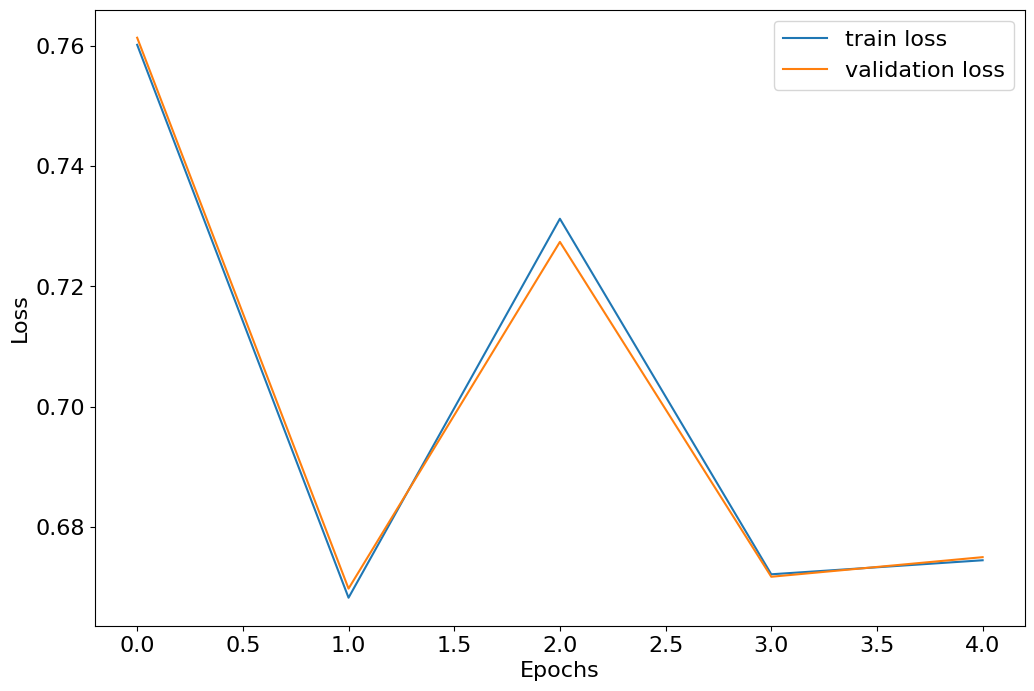

In [126]:
#plotting the training progress
fig = plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 16})

plt.plot(list(range(len(run_history['train_loss']))), run_history['train_loss'])
plt.plot(list(range(len(run_history['train_loss']))), run_history['val_loss'])

plt.ylabel("Loss")
plt.xlabel("Epochs")

plt.legend(["train loss","validation loss"])

plt.show()

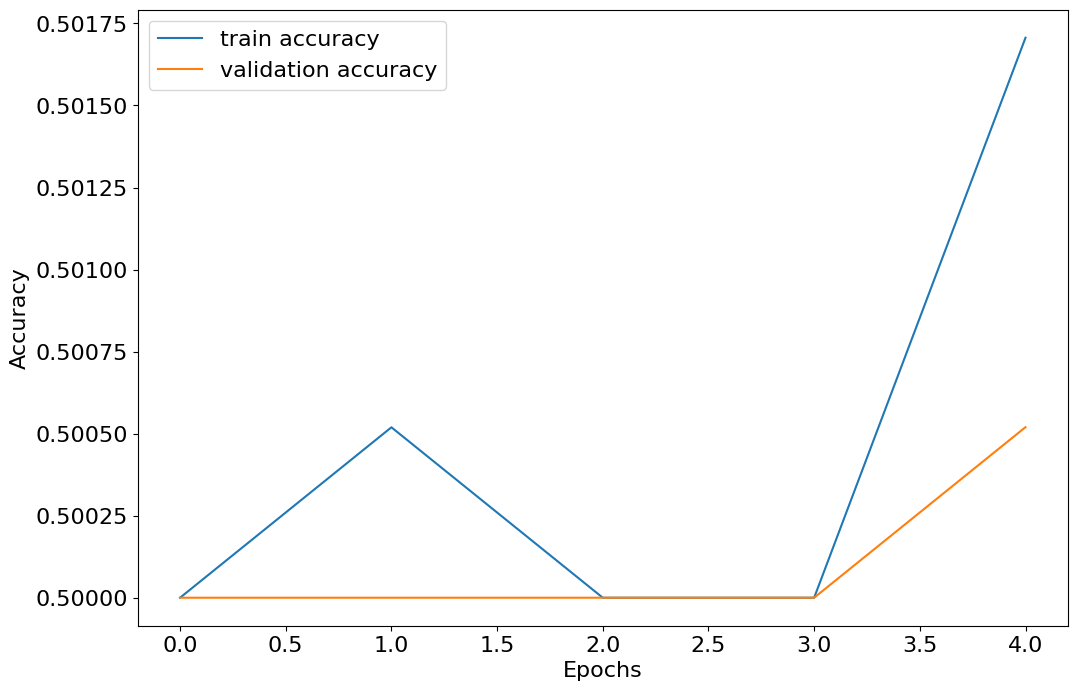

In [127]:
#plotting the training progress
fig = plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 16})

plt.plot(list(range(len(run_history['train_acc']))), run_history['train_acc'])
plt.plot(list(range(len(run_history['train_acc']))), run_history['val_acc'])

plt.ylabel("Accuracy")
plt.xlabel("Epochs")

plt.legend(["train accuracy","validation accuracy"])

plt.show()

# Evaluation

In [128]:
# graph data
train_g = split_graph['graph']
test_pos_g, test_neg_g = split_graph['test_graph']

In [129]:
# calculate predictions
with torch.no_grad():
  h = model(train_g.ndata['feat'])  # get node embeddings
  pos_score = pred(test_pos_g, h)
  neg_score = pred(test_neg_g, h)

scores = torch.cat([pos_score, neg_score])
labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])

Best Threshold=0.576764, F-Score=0.746


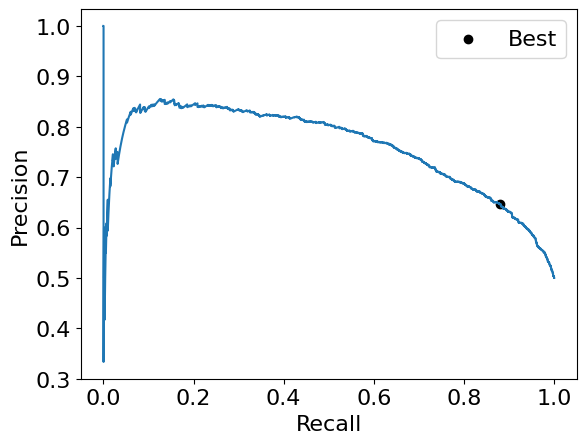

In [130]:
# find the best threshold
# calculate pr curve
precision, recall, thresholds = precision_recall_curve(labels, torch.sigmoid(scores))

# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

# plot the curve
plt.plot(recall, precision)
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [131]:
# calculate preds with best threshold:
preds = torch.where(torch.sigmoid(scores) > thresholds[ix], torch.tensor(1.0), torch.tensor(0.0))

In [132]:
# classification report
print(classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.81      0.52      0.63      1925
         1.0       0.65      0.88      0.75      1925

    accuracy                           0.70      3850
   macro avg       0.73      0.70      0.69      3850
weighted avg       0.73      0.70      0.69      3850



In [133]:
#confusion matrix
cf_matrix = confusion_matrix(labels, preds)

print(cf_matrix)

[[1000  925]
 [ 232 1693]]


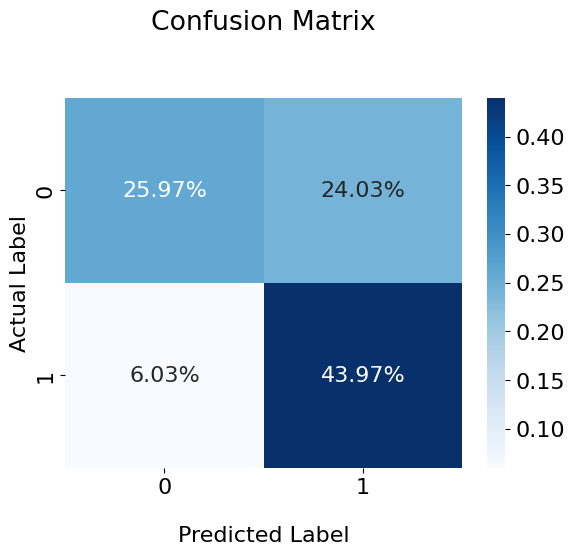

In [134]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('Actual Label');

## Display the visualization of the Confusion Matrix.
plt.show()

In [135]:
! zip -r logs.zip logs

updating: logs/ (stored 0%)
updating: logs/runs/ (stored 0%)
updating: logs/runs/686/ (stored 0%)
updating: logs/runs/686/run_0/ (stored 0%)
updating: logs/runs/686/run_0/0.pt (deflated 65%)
updating: logs/runs/686/run_0/params.csv (deflated 27%)
updating: logs/runs/686/run_0/20.pt (deflated 65%)
updating: logs/runs/686/run_0/best.pt (deflated 65%)
updating: logs/runs/686/run_0/70.pt (deflated 65%)
updating: logs/runs/686/run_0/50.pt (deflated 65%)
updating: logs/runs/686/run_0/10.pt (deflated 65%)
updating: logs/runs/686/run_0/40.pt (deflated 65%)
updating: logs/runs/686/run_0/history.csv (deflated 57%)
updating: logs/runs/686/run_0/60.pt (deflated 65%)
updating: logs/runs/686/run_0/30.pt (deflated 65%)
updating: logs/hyp_opt/ (stored 0%)
updating: logs/hyp_opt/686.csv (deflated 65%)
updating: logs/runs/0/ (stored 0%)
updating: logs/runs/0/run_0/ (stored 0%)
updating: logs/runs/0/run_0/params.csv (deflated 25%)
updating: logs/runs/0/run_0/best.pt (deflated 87%)
updating: logs/runs/0/r